In [1]:
import h5py
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import glob
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import re

import sys
sys.path.append('../')
from model_nobias import Model as NoBiasModel
from loss import loss_cosine_similarity

2024-07-20 14:28:40.317724: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-20 14:28:40.652915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_weights_biases_side_by_side(model1, pdf, title):
    import re
    
    # Iterate over the parameters of the first model and collect names
    params1 = {name: param for name, param in model1.named_parameters()}

    # Get the parameter names for plotting
    parameter_names = [name for name in params1.keys() if 'weight' in name]

    # Custom sorting function
    def custom_sort(name):
        # Extract the number after "conv"
        match = re.search(r'conv(\d+)', name)
        if match:
            return int(match.group(1))
        else:
            return float('inf')  # If no number found, place it at the end

    # Sort parameter_names by the number after "conv"
    parameter_names.sort(key=custom_sort)

    # Create traces for Model 1
    frequencies = []
    max_length = 0
    for name in parameter_names:
        residual_vector_fft = np.fft.fft(params1[name].data.cpu().numpy().flatten())
        residual_vector_magnitude = np.abs(residual_vector_fft)
        frequencies.append(residual_vector_magnitude)
        max_length = max(max_length, len(residual_vector_magnitude))

    # Pad the frequency magnitudes with their average value to the same length
    frequencies = np.array([np.pad(f, (0, max_length - len(f)), 'constant', constant_values=np.mean(f)) if len(f) < max_length else f[:max_length] for f in frequencies])

    # Calculate the mean and standard deviation
    mean = np.mean(frequencies, axis=0)
    std = np.std(frequencies, axis=0)

    mean = mean.flatten()
    std = std.flatten()

    # Plot the mean and standard deviation
    plt.figure(figsize=(5, 3))
    plt.plot(mean, label='Mean Magnitude of Weights')
    plt.fill_between(range(len(mean)), mean - std, mean + std, color='gray', alpha=0.5, label='Standard Deviation of Weights')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.savefig(pdf)
    plt.show()

# Model: Eigenvectors

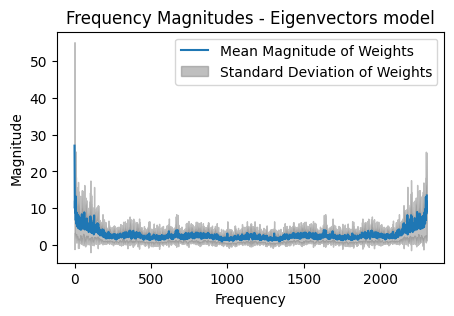

In [3]:
model_eigenvectors = torch.jit.load("../models/eigenvectors_cosine_similarity_skip1_batch64_modelstandard_actrelu.pt")
model_eigenvectors.eval()
plot_weights_biases_side_by_side(model_eigenvectors, "spectral_model_eigenvectors.pdf", "Frequency Magnitudes - Eigenvectors model")

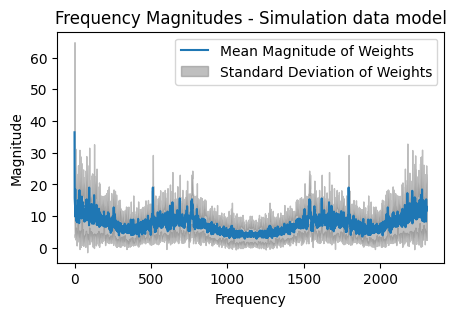

In [4]:
model_simulation = torch.jit.load("../models/simulation_cosine_similarity_skip10_batch64_modelstandard_actrelu.pt")
model_simulation.eval()
plot_weights_biases_side_by_side(model_simulation, "spectral_model_simulation.pdf", "Frequency Magnitudes - Simulation data model")

# Mathematical proof attempt

In [5]:
grid_size_x = 34
grid_size_y = 34
dx = 1 / (grid_size_x)
dy = 1 / (grid_size_y)
dx2 = dx ** 2
dy2 = dy ** 2

# generate Matrix A which is the discretized Laplacian in 2D
A = np.zeros((grid_size_x * grid_size_y, grid_size_x * grid_size_y))
for i in range(grid_size_x):
    for j in range(grid_size_y):
        row = i * grid_size_y + j
        A[row, row] = -2 * (1 / dx2 + 1 / dy2)
        if i > 0:
            A[row, row - grid_size_y] = 1 / dx2
        if i < grid_size_x - 1:
            A[row, row + grid_size_y] = 1 / dx2
        if j > 0:
            A[row, row - 1] = 1 / dy2
        if j < grid_size_y - 1:
            A[row, row + 1] = 1 / dy2

A_inverse = np.linalg.inv(A)

# spectral radius of A
eigenvalues = np.linalg.eigvals(A_inverse)

In [6]:
model_nobias = torch.jit.load("../models/eigenvectors_cosine_similarity_skip1_batch64_modelnobias.pt")
model_nobias.to('cpu')

ValueError: The provided filename ../models/eigenvectors_cosine_similarity_skip1_batch64_modelnobias.pt does not exist

In [ ]:
import torch
import torch.autograd as autograd
import numpy as np

def hessian_matrix(model, loss_fn, data, target):
    model.eval()
    
    # Ensure that the input data requires gradient
    data.requires_grad = True

    # Forward pass
    outputs = model(data)

    # Compute loss
    loss = loss_fn(outputs, target, data, 34, 34)

    # Compute first-order gradients
    grads = autograd.grad(loss, model.parameters(), create_graph=True)

    hessian = []
    for grad in grads:
        grad = grad.view(-1)  # Flatten the gradient
        hessian_row = []
        for g in grad:
            if g.requires_grad:
                # Compute second-order gradients
                grad2 = autograd.grad(g, model.parameters(), create_graph=True)
                hessian_row.append(torch.cat([g.contiguous().view(-1) for g in grad2]))
        if hessian_row:
            hessian.append(torch.stack(hessian_row))

    # Stack rows to form the Hessian matrix
    hessian = torch.cat(hessian, dim=0)

    return hessian

# Load data once
data_path = "../data/eigenvectors_data/b_0.dat"
target_path = "../data/eigenvectors_data/x_0.dat"
eigenvector = np.loadtxt(data_path)
counterpart = np.loadtxt(target_path)

# Convert data to torch tensors
eigenvector = torch.tensor(eigenvector, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
counterpart = torch.tensor(counterpart, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Ensure that model parameters require gradients
for param in model_nobias.parameters():
    param.requires_grad = True

# Usage example
hessian = hessian_matrix(model_nobias, loss_cosine_similarity, eigenvector, counterpart)


KeyboardInterrupt: 

In [ ]:
# trace of Matrix inverse of A
trace_A_inverse = np.trace(A_inverse)
trace_A_inverse

-0.5864028631585678

In [ ]:
hessian_trace

0.014489218642665946